In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# I keep having import issues with plotly so now I will just install it from whatever environment I'm currently in
# import sys
# !conda install --yes --prefix {sys.prefix} plotly
import plotly.graph_objects as go

from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset
from cfl.visualization_methods import clustering_to_sankey as sk


In [2]:
# create a visual bars data set

n_samples = 10000
noise_lvl = 0.00
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data.getImages()
y = vb_data.getTarget()

# format data
x = np.expand_dims(ims, -1)

y = one_hot_encode(y, unique_labels=[0,1])



Generating a visual bars dataset with 10000 samples at noise level 0.0


In [3]:
x.shape[1:]

(10, 10, 1)

All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test\experiment0027
name not specified in input, defaulting to CondExpCNN
Training CFL pipeline.
Epoch 1/5
235/235 - 1s - loss: 0.2493 - val_loss: 0.2461
Epoch 2/5
235/235 - 1s - loss: 0.2270 - val_loss: 0.1913
Epoch 3/5
235/235 - 1s - loss: 0.1697 - val_loss: 0.1514
Epoch 4/5
235/235 - 1s - loss: 0.1515 - val_loss: 0.1429
Epoch 5/5
235/235 - 1s - loss: 0.1482 - val_loss: 0.1405


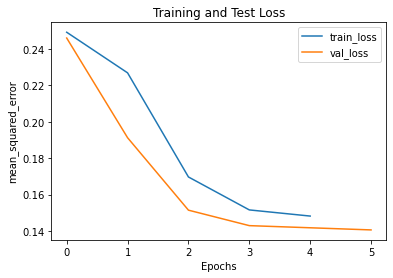

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test\experiment0027\trained_blocks\CondExpCNN


In [4]:
data_info = {'X_dims': x.shape,
             'Y_dims': y.shape,
             'Y_type': 'categorical'}

# # paragmeters for CDE
CNN_params = { # parameters for model creation
                    'filters'         : [32, 16],
                    'input_shape'     : (10, 10, 1),
                    'kernel_size'     : [(3, 3)] *2,
                    'pool_size'       : [(2, 2)] *2,
                    'padding'         : ['same'] *2,
                    'conv_activation' : ['softmax', 'softmax'],
                    'dense_units'     : 16,
                    'dense_activation' : 'softmax',
                    'output_activation': 'softmax',

                    # parameters for training
                    'batch_size'  : 32,
                    'n_epochs'    : 5,
                    'optimizer'   : 'adam',
                    'opt_config'  : {},
                    'verbose'     : 2,
                    'weights_path': None,
                    'loss'        : 'mean_squared_error',
                    'show_plot'   : True,
                    'standardize' : False,
                    'best'        : True,
                    }


block_names = ['CondExpCNN']
block_params = [CNN_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

results = my_exp.train()

In [5]:
my_exp.blocks[0].model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3

In [6]:
pyx = results['CondExpCNN']['pyx']

pyx[:10]

array([[0.378632  , 0.621368  ],
       [0.816699  , 0.18330094],
       [0.7883127 , 0.21168728],
       [0.23304857, 0.76695144],
       [0.17874864, 0.8212514 ],
       [0.12847105, 0.8715289 ],
       [0.12686422, 0.87313575],
       [0.378632  , 0.621368  ],
       [0.13163294, 0.868367  ],
       [0.1341686 , 0.86583143]], dtype=float32)

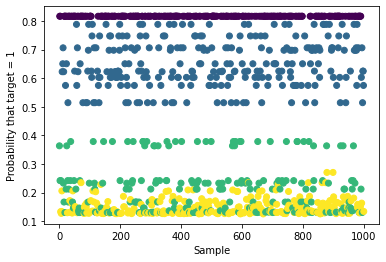

Average prediction for x-class 0: 0.82
Average prediction for x-class 1: 0.65
Average prediction for x-class 2: 0.21
Average prediction for x-class 3: 0.15


In [7]:
truth = vb_data.getGroundTruth()

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# plot them
plt.scatter(range(1000), pyx[plot_idx,0], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,0])))


In [8]:
from cfl.cluster_methods.snn import SNN

cluster_params = {'neighbor_num': 4, 'min_shared_neighbor_proportion' : 0.2 }
snn_obj = SNN('SNN', data_info, cluster_params, random_state=143)

cde_results_dict = results['CondExpCNN']
res = snn_obj.train(Dataset(x, y), cde_results_dict['pyx'])





name specified but not used by SNN


In [10]:
res

(SNN(min_shared_neighbor_proportion=None, neighbor_num=4),
 SNN(min_shared_neighbor_proportion=None, neighbor_num=4))

In [9]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(truth, res['x_lbls'])


TypeError: tuple indices must be integers or slices, not str

In [53]:
# create a number of Kmeans objects with different Ks
k_range = range(2, 8)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2}
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss
x_lbls_L = []
for kmeans_obj in kmeans_l:
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])


In [56]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])

fig.update_layout(title_text="Visual Bars Clustering, noise=0.03, with 2 to 7 Clusters", font_size=10)
fig.show()

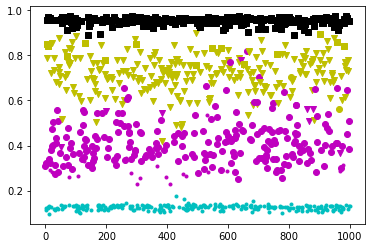

In [77]:
truth = vb_data.getGroundTruth()

# graph the 4 actual clusters against 4 predicted clusters 

# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[2][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.show()



In [ ]:
from cfl.visualization_methods import general_vis as vis

vis.view_class_examples(ims, im_shape, 10, x_lbls_L[0])


In [ ]:
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[1])


# # %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[2])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[3])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[4])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[5])



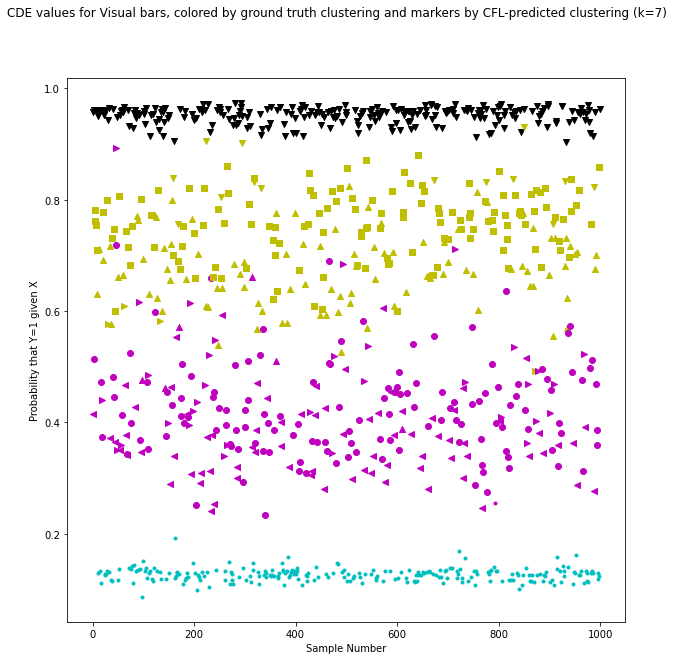

In [82]:
truth = vb_data.getGroundTruth()


# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']


#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
fig = plt.figure(figsize=(10, 10))
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[5][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.xlabel("Sample Number")
plt.ylabel("Probability that Y=1 given X")
plt.suptitle('CDE values for Visual bars, colored by ground truth clustering and markers by CFL-predicted clustering (k=7)')
plt.show()
